# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [6]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Test start

In [109]:
scores_test = X_dev.dot(W)
scores_test.shape

(500, 10)

In [124]:
probabilities = scores

In [ ]:
probabilities[np.arange(num_train, y)] -= 1

## Test end

## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [133]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.372248
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$
- As we initialise our weights close to 0, we expect each class probability to be equal, giving us approximately 0.1 (1/num_classes=10). 
- Then when we take the loss, we take the negative log, which gives us -log(0.1).


In [134]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.086437 analytic: -0.086437, relative error: 1.697361e-07
numerical: -0.229631 analytic: -0.229631, relative error: 9.369140e-08
numerical: -3.244937 analytic: -3.244937, relative error: 1.172774e-08
numerical: 0.529596 analytic: 0.529596, relative error: 4.851785e-08
numerical: -0.649264 analytic: -0.649264, relative error: 4.172009e-08
numerical: -0.491198 analytic: -0.491198, relative error: 2.663667e-09
numerical: 0.972570 analytic: 0.972570, relative error: 1.277954e-08
numerical: 1.849331 analytic: 1.849331, relative error: 9.547392e-10
numerical: -3.494588 analytic: -3.494588, relative error: 7.385459e-09
numerical: 2.090278 analytic: 2.090278, relative error: 1.395280e-08
numerical: 0.367102 analytic: 0.367103, relative error: 8.930293e-08
numerical: -0.334087 analytic: -0.334087, relative error: 1.662505e-08
numerical: 3.673228 analytic: 3.673228, relative error: 9.148936e-09
numerical: -7.556495 analytic: -7.556495, relative error: 1.577270e-09
numerical: 2.26660

In [135]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.372248e+00 computed in 0.084009s
vectorized loss: 2.372248e+00 computed in 0.005031s
Loss difference: 0.000000
Gradient difference: 0.000000


In [142]:
softmax_loss_vectorized()

TypeError: softmax_loss_vectorized() missing 4 required positional arguments: 'W', 'X', 'y', and 'reg'

In [150]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
# Initial exploration
# learning_rates = [1e-8, 4e-8, 8e-8, 1e-7, 4e-7, 8e-7, 1e-6, 4e-6, 8e-6, 1e-5, 4e-5, 8e-5, 1e-4, 4e-4, 8e-4]
# regularization_strengths = [1e4, 2e4, 3e4, 4e4, 5e4]

# Second iteration: best parameters were [8e-7, 1e4]
# learning_rates = [7e-7, 7.2e-7, 7.4e-7, 7.6e-7, 7.8e-7, 7.9e-7, 8e-7, 8.2e-7, 8.4e-7, 8.6e-7, 8.8e-7, 8.9e-7, 9e-7]
# regularization_strengths = [0.5e4, 0.6e4, 0.7e4, 0.8e4, 0.9e4, 1e4, 1.1e4, 1.2e4, 1.3e4, 1.4e4, 1.5e4]

# Best
learning_rates = [7e-7, 8e-7, 8.8e-7, 9e-7]
regularization_strengths = [0.6e4, 0.7e4, 1e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_iters = [1000, 1500]

for lr_i in learning_rates:
    for reg_i in regularization_strengths:
        model_val = Softmax()
        loss_hist = model_val.train(X_train, y_train, learning_rate=lr_i, reg=reg_i,
                          num_iters=num_iters[1], verbose=True)
        
        y_train_pred = model_val.predict(X_train)
        y_val_pred = model_val.predict(X_val)
        
        curr_accuracy_train = np.mean(y_train == y_train_pred)
        curr_accuracy_val = np.mean(y_val == y_val_pred)
        print(f'learning rate: {lr_i}, reg: {reg_i}')
        print(f'train accuracy: {curr_accuracy_train}, validation accuracy: {curr_accuracy_val}')
        
        results[lr_i, reg_i] = [curr_accuracy_train, curr_accuracy_val]
        
        if curr_accuracy_val > best_acc_val:
            best_acc_val = curr_accuracy_val
            best_softmax = model_val

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_acc_val)

iteration 0 / 1500: loss 187.643893
iteration 100 / 1500: loss 35.443685
iteration 200 / 1500: loss 8.141393
iteration 300 / 1500: loss 3.054042
iteration 400 / 1500: loss 2.147338
iteration 500 / 1500: loss 2.056977
iteration 600 / 1500: loss 1.916204
iteration 700 / 1500: loss 1.956541
iteration 800 / 1500: loss 1.994094
iteration 900 / 1500: loss 2.029352
iteration 1000 / 1500: loss 1.914098
iteration 1100 / 1500: loss 1.999908
iteration 1200 / 1500: loss 1.960015
iteration 1300 / 1500: loss 2.053073
iteration 1400 / 1500: loss 1.920726
learning rate: 7e-07, reg: 6000.0
train accuracy: 0.3641632653061225, validation accuracy: 0.372
iteration 0 / 1500: loss 223.178978
iteration 100 / 1500: loss 32.149600
iteration 200 / 1500: loss 6.145408
iteration 300 / 1500: loss 2.613616
iteration 400 / 1500: loss 2.071216
iteration 500 / 1500: loss 2.024853
iteration 600 / 1500: loss 2.040269
iteration 700 / 1500: loss 2.002821
iteration 800 / 1500: loss 1.983593
iteration 900 / 1500: loss 1.924

In [151]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.361000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$
- The reason for this is because for SVM, if you add a datapoint to the training set and its highest class score is for the correct class and greater than the safety margin, then the datapoint loss will be zero and it will not change the overall training loss (since we've not normalised it by the number of training samples).
- This is not the case for Softmax, since each image will add a non-zero amount of training loss (given that the non-correct class scores are non-zero).

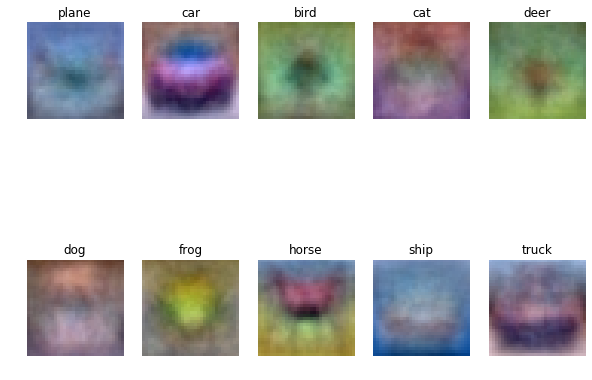

In [152]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])